In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util
import mikkel_tools.GMT_tools as gt

# ChaosMagPy modules
from chaosmagpy import load_CHAOS_matfile
from chaosmagpy.model_utils import synth_values
from chaosmagpy.data_utils import mjd2000

import numpy as np
from math import inf
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
import pyshtools
import pickle

comment = "Swarm observations with tapered ensemble as prior"
nb_name = "nb_case_core_vires_swarm_obs"

In [157]:
shc_g = 30
shc_grid = 60

core = SDSS(comment, N_SH = shc_g, sim_type = "core_ens", sat_height = 350)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([core.grid_phi, 90-core.grid_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = False)
core.generate_map()

In [158]:
core.condtab(normsize=10000, quantiles = 1000, 
             rangn_lim = 3.5, rangn_N = 501, rangv_lim = 2.0, rangv_N = 101, model_hist = "ensemble") #model_hist = "ensemble"

# Covariance model

All eigenvalues > 0: True
Cov model is pos def: True


<IPython.core.display.Javascript object>


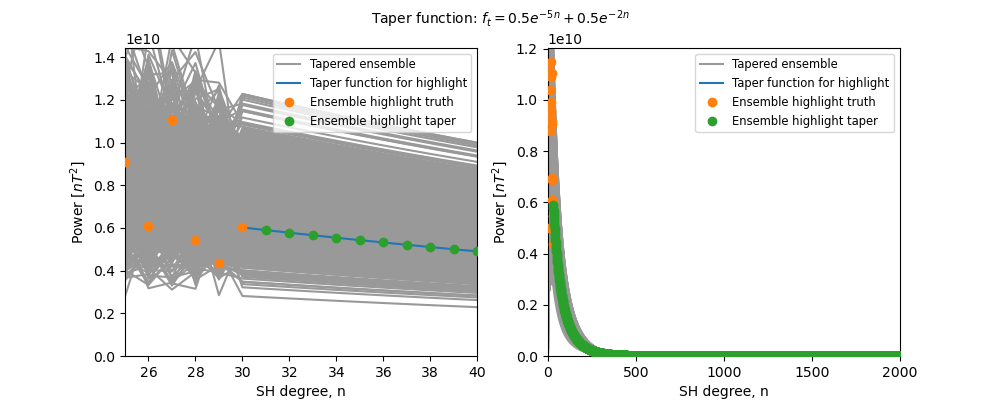

In [159]:
core.cov_model_taper(r_at = core.r_cmb, tap_to = 4000, tap_exp_p1 = 5, tap_exp_p2 = 2,
                     tap_scale_start = 0, tap_scale_end = 24, plot_taper = True)

# Swarm observations through VirES VRE

In [7]:
import datetime as dt
from viresclient import SwarmRequest

request = SwarmRequest()

In [8]:
request.available_auxiliaries()

['Timestamp',
 'Latitude',
 'Longitude',
 'Radius',
 'Spacecraft',
 'OrbitDirection',
 'QDOrbitDirection',
 'SyncStatus',
 'Kp10',
 'Kp',
 'Dst',
 'F107',
 'IMF_BY_GSM',
 'IMF_BZ_GSM',
 'IMF_V',
 'F10_INDEX',
 'OrbitSource',
 'OrbitNumber',
 'AscendingNodeTime',
 'AscendingNodeLongitude',
 'QDLat',
 'QDLon',
 'QDBasis',
 'MLT',
 'SunDeclination',
 'SunHourAngle',
 'SunRightAscension',
 'SunAzimuthAngle',
 'SunZenithAngle',
 'SunLongitude',
 'SunVector',
 'DipoleAxisVector',
 'NGPLatitude',
 'NGPLongitude',
 'DipoleTiltAngle']

In [9]:
request.available_models(details=True)

AMPS = AMPS()
  START: 1900-01-01T00:00:00Z
  END:   2025-01-01T00:00:00Z
DESCRIPTION:
AMPS - associated magnetic field, https://github.com/klaundal/pyAMPS
SOURCES:
  SW_OPER_MIO_SHA_2E_00000000T000000_99999999T999999_0103

CHAOS = 'CHAOS-Core'(max_degree=20,min_degree=1) + 'CHAOS-Static'(max_degree=185,min_degree=21) + 'CHAOS-MMA-Primary'(max_degree=2,min_degree=1) + 'CHAOS-MMA-Secondary'(max_degree=2,min_degree=1)
  START: 2002-01-01T00:00:00Z
  END:   2020-12-13T23:30:00Z
DESCRIPTION:
Alias for 'CHAOS-Core' + 'CHAOS-Static' + 'CHAOS-MMA-Primary' + 'CHAOS-MMA-Secondary'
SOURCES:
  CHAOS-7_static.shc
  SW_OPER_MCO_SHA_2X_19970101T000000_20210131T235959_0704
  SW_OPER_MMA_CHAOS__20020101T000000_20021231T233000_0701
  SW_OPER_MMA_CHAOS__20030101T000000_20031231T233000_0701
  SW_OPER_MMA_CHAOS__20040101T000000_20041231T233000_0701
  SW_OPER_MMA_CHAOS__20050101T000000_20051231T233000_0701
  SW_OPER_MMA_CHAOS__20060101T000000_20061231T233000_0701
  SW_OPER_MMA_CHAOS__20070101T000000_200712

In [10]:
collect = "SW_OPER_MAGA_LR_1B"
use_meas = ["B_NEC"]
use_aux = ["SunZenithAngle", "Kp", "QDLat", "Dst", "IMF_BZ_GSM"]

use_models = ["LCS1='LCS-1'(min_degree=1, max_degree=185)", "CHAOS-MMA", "MIO_SHA_2C"] # "CHAOS='CHAOS-Core'(min_degree=15, max_degree=20)"

samp_step = "PT5M"

In [11]:
request.set_collection(collect)

request.set_products(measurements=use_meas,
                     models = use_models,
                     auxiliaries=use_aux,
                     residuals=False,
                     sampling_step=samp_step)
                     #sampling_step="PT12M") # could be reduced

#date_start = [2018,8,1]
#date_end = [2019,8,1]
date_start = [2018,11,1]
date_end = [2019,11,1]
data = request.get_between(start_time=dt.datetime(date_start[0],date_start[1],date_start[2]),
                           end_time=dt.datetime(date_end[0],date_end[1],date_end[2])) # Above 3 months could lead to secular variation "error"

ds = data.as_xarray()

[1/1] Processing:  100%|██████████|  [ Elapsed: 03:26, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (17.92MB)


In [12]:
SZA_angle = 120
Kp_max = 2
dDst_dt_max = 2
Dst_abs_max = 30
QDlat_max = 90
IMF_BZ_min = 0.0

dDst_dt = (abs(np.diff(ds.Dst.values,prepend=0))/5)*60 #(nT/5min)/5 * 60min/hr -> nT/hr
Dst_abs = abs(ds.Dst.values)

idx_sort = np.logical_and.reduce((np.abs(ds.SunZenithAngle.values)>SZA_angle, 
                                  ds.Kp.values<=Kp_max, abs(ds.QDLat.values)<QDlat_max, 
                                  dDst_dt<=dDst_dt_max, Dst_abs < Dst_abs_max,
                                  ds.IMF_BZ_GSM>IMF_BZ_min))

In [13]:
obs_sat = SDSS(comment, N_SH = shc_g)

obs_sat.r_grid = ds.Radius[idx_sort].values/10**3
obs_sat.lon = ds.Longitude[idx_sort].values
obs_sat.lat = ds.Latitude[idx_sort].values
obs_sat.grid_N = len(obs_sat.lat)
print(obs_sat.grid_N)

4884


In [14]:
# chaosmagpy
N_chaos = 20
CHAOS7 = load_CHAOS_matfile('mikkel_tools/models_shc/CHAOS-7.mat')
# Start
chaos_time = mjd2000(date_start[0],date_start[1],date_start[2])
g_CHAOS7 = CHAOS7.synth_coeffs_tdep(chaos_time, nmax=20, deriv=0)
A_r, A_theta, A_phi = gt.design_SHA(obs_sat.r_grid/core.a, (90-obs_sat.lat)*core.rad, obs_sat.lon*core.rad, N_chaos)
B_CHAOS7_start = np.matmul(A_r,g_CHAOS7)

M_use = ds["B_NEC_LCS1"].values[:,2][idx_sort] + ds["B_NEC_CHAOS-MMA"].values[:,2][idx_sort] #+ ds["B_NEC_MIO_SHA_2C"].values[:,2][idx_sort]  

B_delta_SV =-ds["B_NEC"].values[:,2][idx_sort] + M_use - B_CHAOS7_start

In [15]:

obs_sat.data = -ds["B_NEC"].values[:,2][idx_sort] + M_use - B_delta_SV


<IPython.core.display.Javascript object>


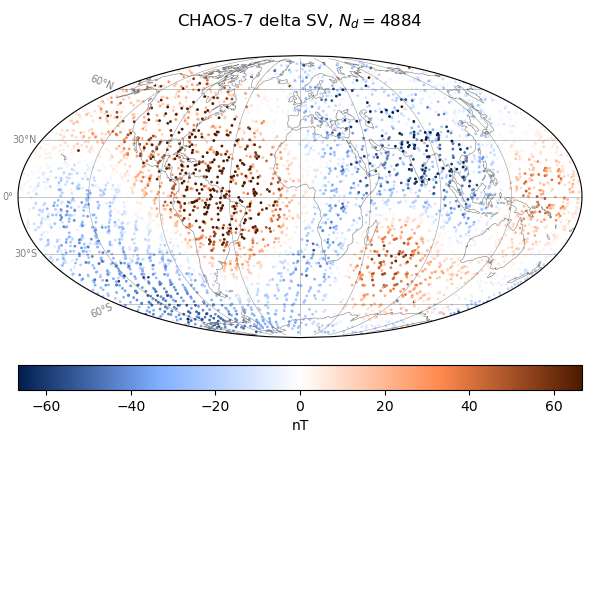

In [16]:
mt_util.plot_global(lat = obs_sat.lat, lon = obs_sat.lon, data=B_delta_SV, limits_data = [-100,100],
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='CHAOS-7 delta SV, $N_d={}$'.format(obs_sat.grid_N), point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_core_vires_swarm_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

<IPython.core.display.Javascript object>


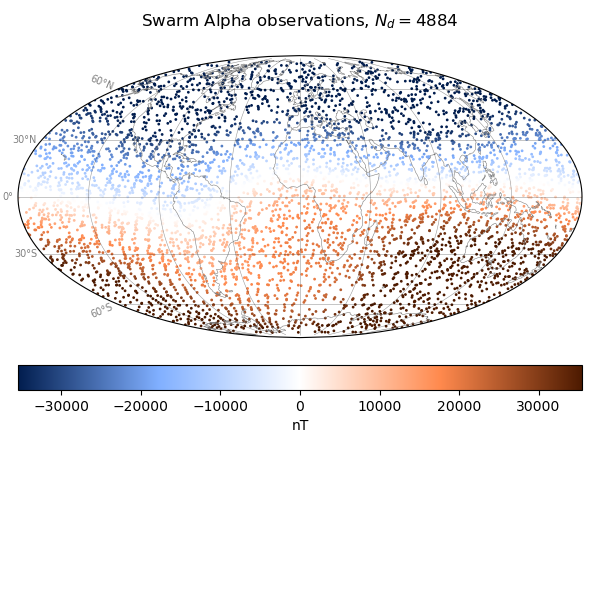

<IPython.core.display.Javascript object>


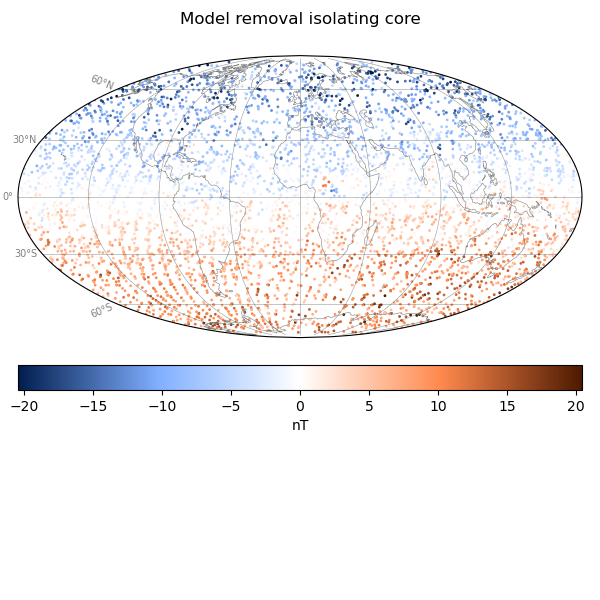

In [17]:
mt_util.plot_global(lat = obs_sat.lat, lon = obs_sat.lon, data=obs_sat.data, 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Swarm Alpha observations, $N_d={}$'.format(obs_sat.grid_N), point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_core_vires_swarm_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

mt_util.plot_global(lat = obs_sat.lat, lon = obs_sat.lon, data=-M_use, 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Model removal isolating core', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

# System equations

In [160]:
C_e_const = 6
core.integrating_kernel(obs_sat, C_e_const = C_e_const, C_mm_supply = core.C_ens_tap)

# LSQ

In [161]:
core.covmod_lsq_equiv(obs_sat.data, core.C_ens_tap, core.G, core.r_cmb)

<IPython.core.display.Javascript object>


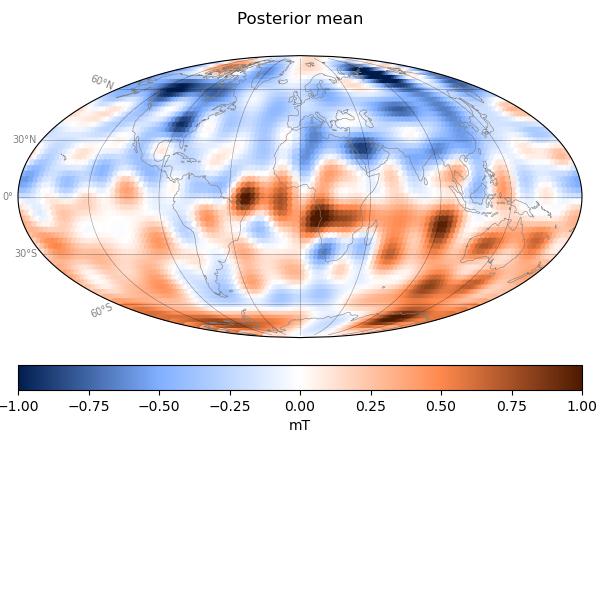

In [164]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

limit_data = [-1,1]

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=np.array(core.m_equiv_lsq).reshape(-1,), limits_data = limit_data,
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Posterior mean', point_size=20,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

In [143]:
core.ensemble_B(core.g_equiv_lsq, nmax = 30, r_at = core.r_cmb, grid_type = "glq")
lsq_eqa = core.B_ensemble[:,0].copy()

In [144]:
np.allclose(lsq_eqa,np.array(core.m_equiv_lsq).reshape(-1,))

False

In [145]:
np.array(core.m_equiv_lsq).reshape(-1,)[:10]

array([25054.54124886, 33294.72077411, 41127.60297215, 48440.09554526,
       55137.03563821, 61140.5747371 , 66397.70347387, 70874.33683988,
       74557.96055457, 77456.81014299])

In [146]:
lsq_eqa[:10]

array([24931.07325072, 33280.5280671 , 41221.60360142, 48638.55201211,
       55433.61146672, 61529.42429809, 66870.43847371, 71423.27323238,
       75176.0701568 , 78136.88813582])

# SDSSIM

 |OOOOOOOOOO| 100.0%   realization nr. 0. Counter: 7381/7381, Running error magnitude: 5.6
Run time: 5.567 hours 
Total elapsed time: 5.567 hours 
Variance: 385462929400.778
Mean: 5754.967
Max: 3482044.415
Min: -5520949.165
Run nr.: 1


Seqsim RMSE:	 [[1.78802539]]


<IPython.core.display.Javascript object>


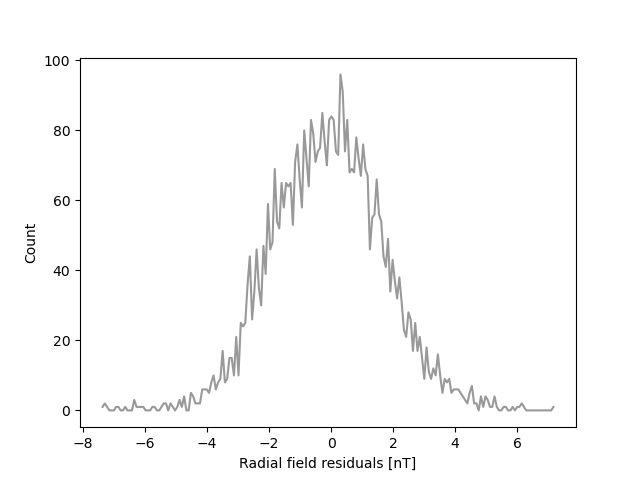

In [165]:
N_sim = 1
core.target_var = np.max(core.C_ens_tap)

core.run_sim(N_sim, core.grid_N, core.C_mm_all, core.C_dd, core.C_dm_all, core.G,
        obs_sat.data, core.data, scale_m_i = True, unit_d = False, collect_all = True,
        sense_running_error = True, save_string = nb_name, sim_stochastic = False, solve_cho = True)

In [166]:
core.realization_to_sh_coeff(core.r_cmb, set_nmax = shc_grid)

In [170]:
print(core)


______current attributes______

a:                  6371.2
r_sat:              6721.2
r_cmb:              3480.0
rad:                0.017453292519943295
mu0:                1.2566370614359173e-06
comment:            Swarm observations with tapered ensemble as prior
class_abs_path:     /home/mikotz/spherical_direct_sequential_simulation
N_SH:               30
N_SH_secondary:     None
sim_type:           core_ens
grid_zero:          (401,), Max/Min: 1.00 / -1.00
grid_w_shtools:     (401,), Max/Min: 0.01 / 0.00
grid_shape:         (2,), Max/Min: 801.00 / 401.00
grid_w:             (321201,), Max/Min: 0.01 / 0.00
grid_radial:        (321201,), Max/Min: 3480.00 / 3480.00
grid_theta:         (321201,), Max/Min: 179.66 / 0.34
grid_phi:           (321201,), Max/Min: 359.55 / 0.00
grid_N:             321201
grid_nmax:          400
r_grid:             3480.0
grid:               (7381, 2)
sph_d:              None
lon:                (7381,), Max/Min: 357.02 / 0.00
lat:                (7381,), M

In [401]:
core.grid_glq(nmax = 60, r_at = core.r_cmb)
core.ensemble_B(core.g_spec, nmax = 30, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0].copy()

In [189]:
np.allclose(core.m_DSS,zs_eqa)

False

In [402]:
print(core.m_DSS[:10])
print("")
print(zs_eqa[:10])

[[ 178015.42162094]
 [  -4744.31476569]
 [-220668.11158862]
 [-473278.1310948 ]
 [-715969.32582395]
 [-884338.93165672]
 [-923923.50307465]
 [-830175.75377359]
 [-651794.11477444]
 [-466506.56291772]]

[[-16999.69041455]
 [-15935.89906462]
 [-14873.03419927]
 [-13797.49344166]
 [-12698.36231127]
 [-11567.66585474]
 [-10400.56270432]
 [ -9195.47300867]
 [ -7954.13357215]
 [ -6681.57582927]]


In [370]:
g_lsq, _ = mt_util.sh_expand_glq(np.array(core.m_equiv_lsq).reshape(-1,), core.grid_nmax, 
                              core.grid_w_shtools, core.grid_zero, 60, geomag_r_at = core.r_cmb)

g_lsq = np.array(g_lsq).T

In [371]:
g_lsq.shape

(3720,)

In [372]:
g_lsq[:20]

array([-29411.81094888,  -1459.62261777,   4682.60334781,  -2486.50564213,
         2990.14289652,  -2956.1688882 ,   1679.08320418,   -707.67522982,
         1360.83018743,  -2373.85073075,    -89.05359897,   1232.39351026,
          243.07574118,    539.7680773 ,   -543.90521787,    904.36882536,
          811.20616445,    281.93600573,     93.28070325,   -166.25357035])

In [373]:
core.g_equiv_lsq[:20]

array([-29411.81094888,  -1459.62261777,   4682.60334781,  -2486.50564213,
         2990.14289652,  -2956.1688882 ,   1679.08320418,   -707.67522982,
         1360.83018743,  -2373.85073075,    -89.05359897,   1232.39351026,
          243.07574118,    539.7680773 ,   -543.90521787,    904.36882536,
          811.20616445,    281.93600573,     93.28070325,   -166.25357035])

In [374]:
core.grid_glq(nmax = 60, r_at = core.r_cmb)
core.ensemble_B(g_lsq, nmax = 60, r_at = core.r_cmb, grid_type = "glq")
zs_lsq = core.B_ensemble[:,0].copy()

In [375]:
np.allclose(np.array(core.m_equiv_lsq).reshape(-1,),zs_lsq)

False

In [376]:
np.array(core.m_equiv_lsq).reshape(-1,1)[:10]

array([[15054.84104311],
       [18915.33875015],
       [22671.15077144],
       [26302.20176515],
       [29790.08772784],
       [33114.30333495],
       [36261.01105475],
       [39214.86936036],
       [41961.5653978 ],
       [44493.82385519]])

In [378]:
zs_lsq[:10].reshape(-1,1)

array([[14943.33125001],
       [18810.19031158],
       [22573.86449524],
       [26213.33513147],
       [29708.87967388],
       [33042.30354698],
       [36197.1310803 ],
       [39158.7526246 ],
       [41914.52600348],
       [44453.83152042]])

<IPython.core.display.Javascript object>


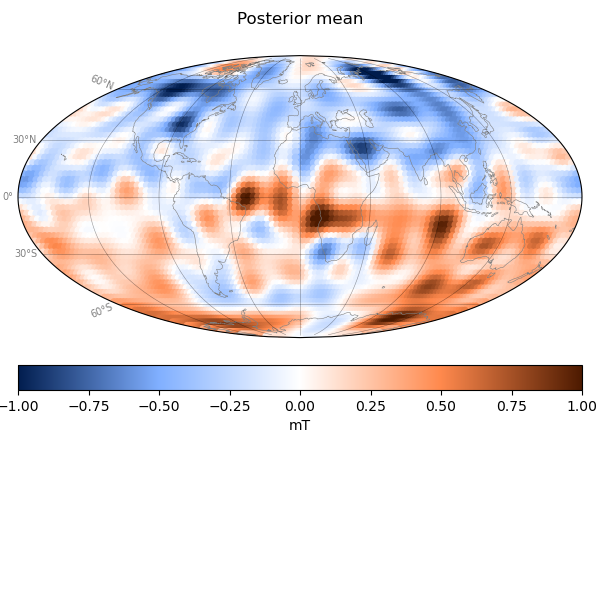

In [379]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

limit_data = [-1,1]

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=zs_lsq, limits_data = limit_data,
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Posterior mean', point_size=20,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

In [240]:
core.ensemble_B(g_CHAOS7, nmax = 13, r_at = core.r_cmb, grid_type = "glq")
zs_chaos = core.B_ensemble[:,0].copy()

In [241]:
g_c, _ = mt_util.sh_expand_glq(zs_chaos, core.grid_nmax, 
                              core.grid_w_shtools, core.grid_zero, 30, geomag_r_at = core.r_cmb)

g_c = np.array(g_c).T

In [242]:
core.ensemble_B(g_c, nmax = 20, r_at = core.r_cmb, grid_type = "glq")
zs_chaos_sht = core.B_ensemble[:,0].copy()

In [243]:
np.allclose(zs_chaos,zs_chaos_sht)

True

In [385]:
np.hstack((zs_chaos[:10].reshape(-1,1),np.array(core.m_equiv_lsq).reshape(-1,1)[:10],zs_lsq[:10].reshape(-1,1)))

array([[-27446.19863388,  15054.84104311,  14943.33125001],
       [-31800.95015755,  18915.33875015,  18810.19031158],
       [-36063.60077684,  22671.15077144,  22573.86449524],
       [-40232.73160689,  26302.20176515,  26213.33513147],
       [-44306.29124574,  29790.08772784,  29708.87967388],
       [-48281.4702703 ,  33114.30333495,  33042.30354698],
       [-52154.59526446,  36261.01105475,  36197.1310803 ],
       [-55921.04436479,  39214.86936036,  39158.7526246 ],
       [-59575.18593689,  41961.5653978 ,  41914.52600348],
       [-63110.34160115,  44493.82385519,  44453.83152042]])

<IPython.core.display.Javascript object>


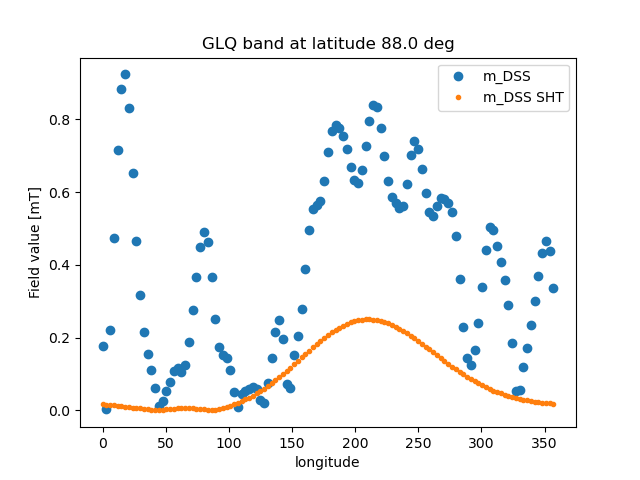

In [404]:
i_max = 121
plt.figure()
#plt.plot(core.lon[:i_max],abs(zs_chaos[:i_max].reshape(-1,1))*10**(-6),'o',label="CHAOS-7")
#plt.plot(core.lon[:i_max],abs(np.array(core.m_equiv_lsq).reshape(-1,1)[:i_max])*10**(-6),'o',label="LSQ")
#plt.plot(core.lon[:i_max],abs(zs_lsq[:i_max])*10**(-6),'o',markersize=3,label="SHT LSQ")
plt.plot(core.lon[:i_max],abs(core.m_DSS.reshape(-1,1)[:i_max])*10**(-6),'o',label="m_DSS")
plt.plot(core.lon[:i_max],abs(zs_eqa[:i_max])*10**(-6),'o',markersize=3,label="m_DSS SHT")
plt.ylabel("Field value [mT]")
plt.xlabel("longitude")
plt.title("GLQ band at latitude {} deg".format(np.round(core.lat[0])))
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


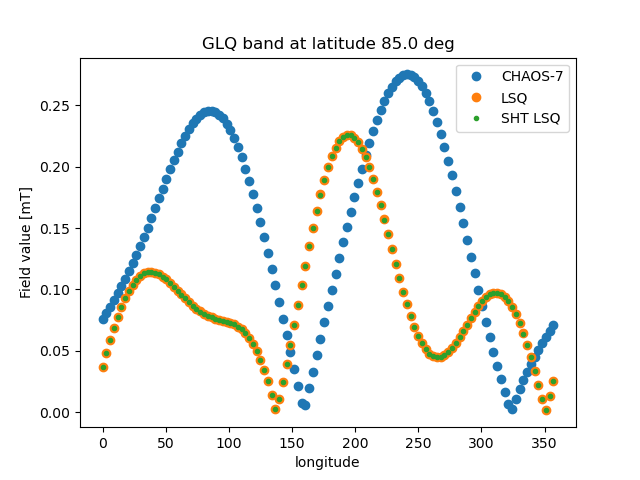

In [396]:
i_max_2 = 242

plt.figure()
plt.plot(core.lon[i_max:i_max_2],abs(zs_chaos[i_max:i_max_2].reshape(-1,1))*10**(-6),'o',label="CHAOS-7")
plt.plot(core.lon[i_max:i_max_2],abs(np.array(core.m_equiv_lsq).reshape(-1,1)[i_max:i_max_2])*10**(-6),'o',label="LSQ")
plt.plot(core.lon[i_max:i_max_2],abs(zs_lsq[i_max:i_max_2])*10**(-6),'o',markersize=3,label="SHT LSQ")

plt.ylabel("Field value [mT]")
plt.xlabel("longitude")
plt.title("GLQ band at latitude {} deg".format(np.round(core.lat[i_max+1])))
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


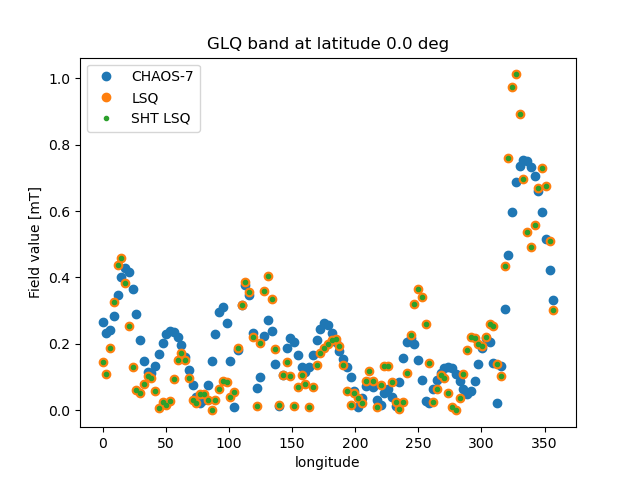

In [397]:
i_max = 3630
i_max_2 = 3751

plt.figure()
plt.plot(core.lon[i_max:i_max_2],abs(zs_chaos[i_max:i_max_2].reshape(-1,1))*10**(-6),'o',label="CHAOS-7")
plt.plot(core.lon[i_max:i_max_2],abs(np.array(core.m_equiv_lsq).reshape(-1,1)[i_max:i_max_2])*10**(-6),'o',label="LSQ")
plt.plot(core.lon[i_max:i_max_2],abs(zs_lsq[i_max:i_max_2])*10**(-6),'o',markersize=3,label="SHT LSQ")

plt.ylabel("Field value [mT]")
plt.xlabel("longitude")
plt.title("GLQ band at latitude {} deg".format(np.round(core.lat[i_max+1])))
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


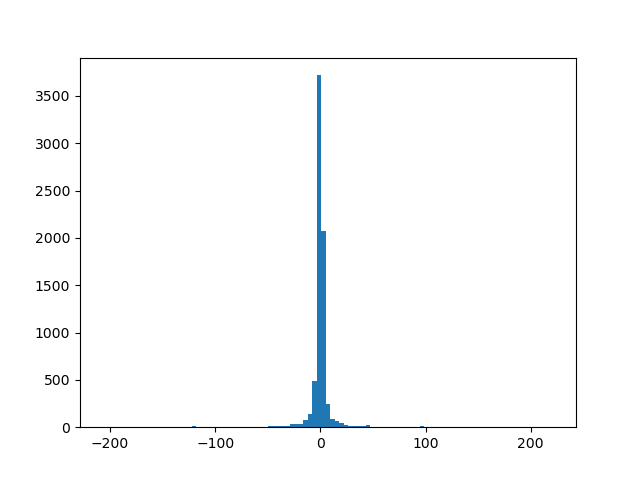

In [400]:
plt.figure()
plt.hist(np.array(core.m_equiv_lsq).reshape(-1,)-zs_lsq.reshape(-1,),bins=101)
plt.show()

In [185]:
R_60 = mt_util.lowe_shspec(60,core.r_cmb,core.a,core.g_spec)
R_30 = mt_util.lowe_shspec(30,core.r_cmb,core.a,core.g_spec)
R_chaos = mt_util.lowe_shspec(20,core.r_cmb,core.a,g_CHAOS7.reshape(-1,1))

In [177]:
g_CHAOS7.shape

(440,)

<IPython.core.display.Javascript object>


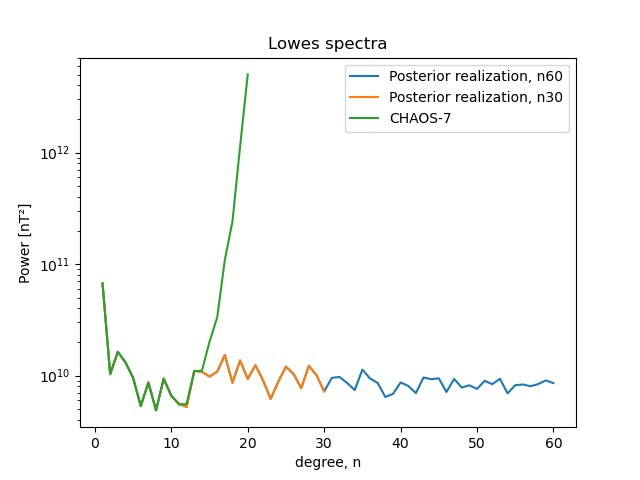

In [186]:
plt.figure()
plt.semilogy(np.arange(1,61),R_60,label="Posterior realization, n60")
plt.semilogy(np.arange(1,31),R_30,label="Posterior realization, n30")
plt.semilogy(np.arange(1,21),R_chaos,label="CHAOS-7")
plt.xlabel("degree, n")
plt.ylabel("Power [nT²]")
plt.title("Lowes spectra")
plt.legend(loc="best")
plt.show()

# n = 60

<IPython.core.display.Javascript object>


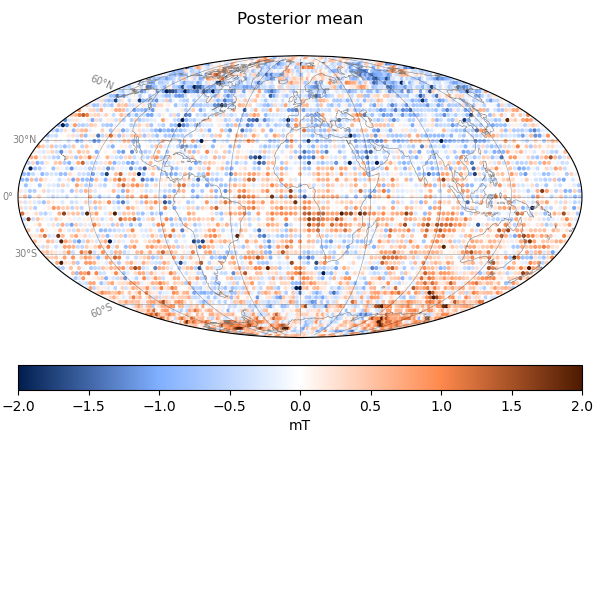

<IPython.core.display.Javascript object>


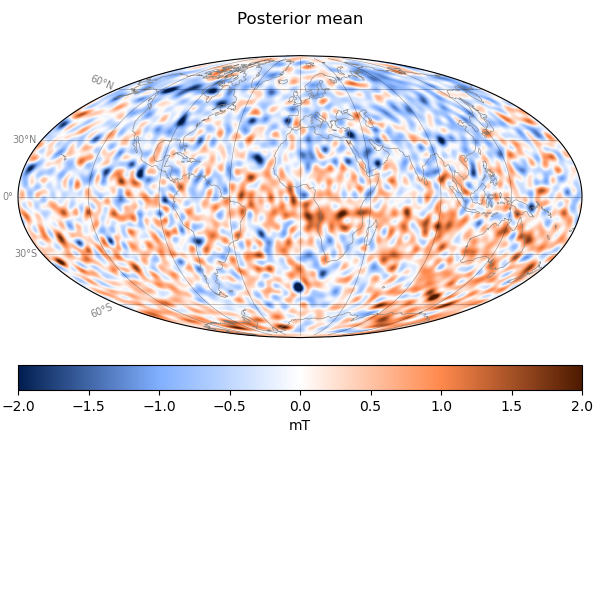

<IPython.core.display.Javascript object>


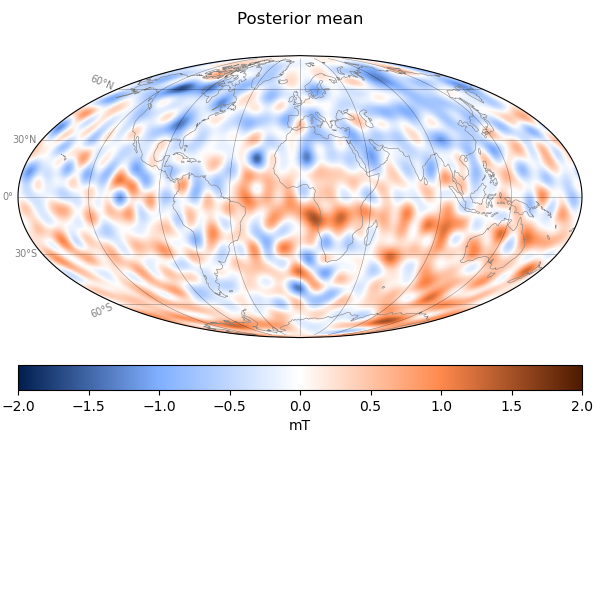

In [187]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

core.grid_glq(nmax = 60, r_at = core.r_cmb)

limit_data = [-2,2]
core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=core.m_DSS, limits_data = limit_data,
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Posterior mean', point_size=4,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

core.grid_glq(nmax = 400, r_at = core.r_cmb)

set_nmax = shc_grid

core.ensemble_B(core.g_spec, nmax = 60, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0].copy()

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=zs_eqa, limits_data = limit_data,
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Posterior mean', point_size=0.1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

core.ensemble_B(core.g_spec, nmax = 30, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0].copy()

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=zs_eqa, limits_data = limit_data,
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Posterior mean', point_size=0.1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

<IPython.core.display.Javascript object>


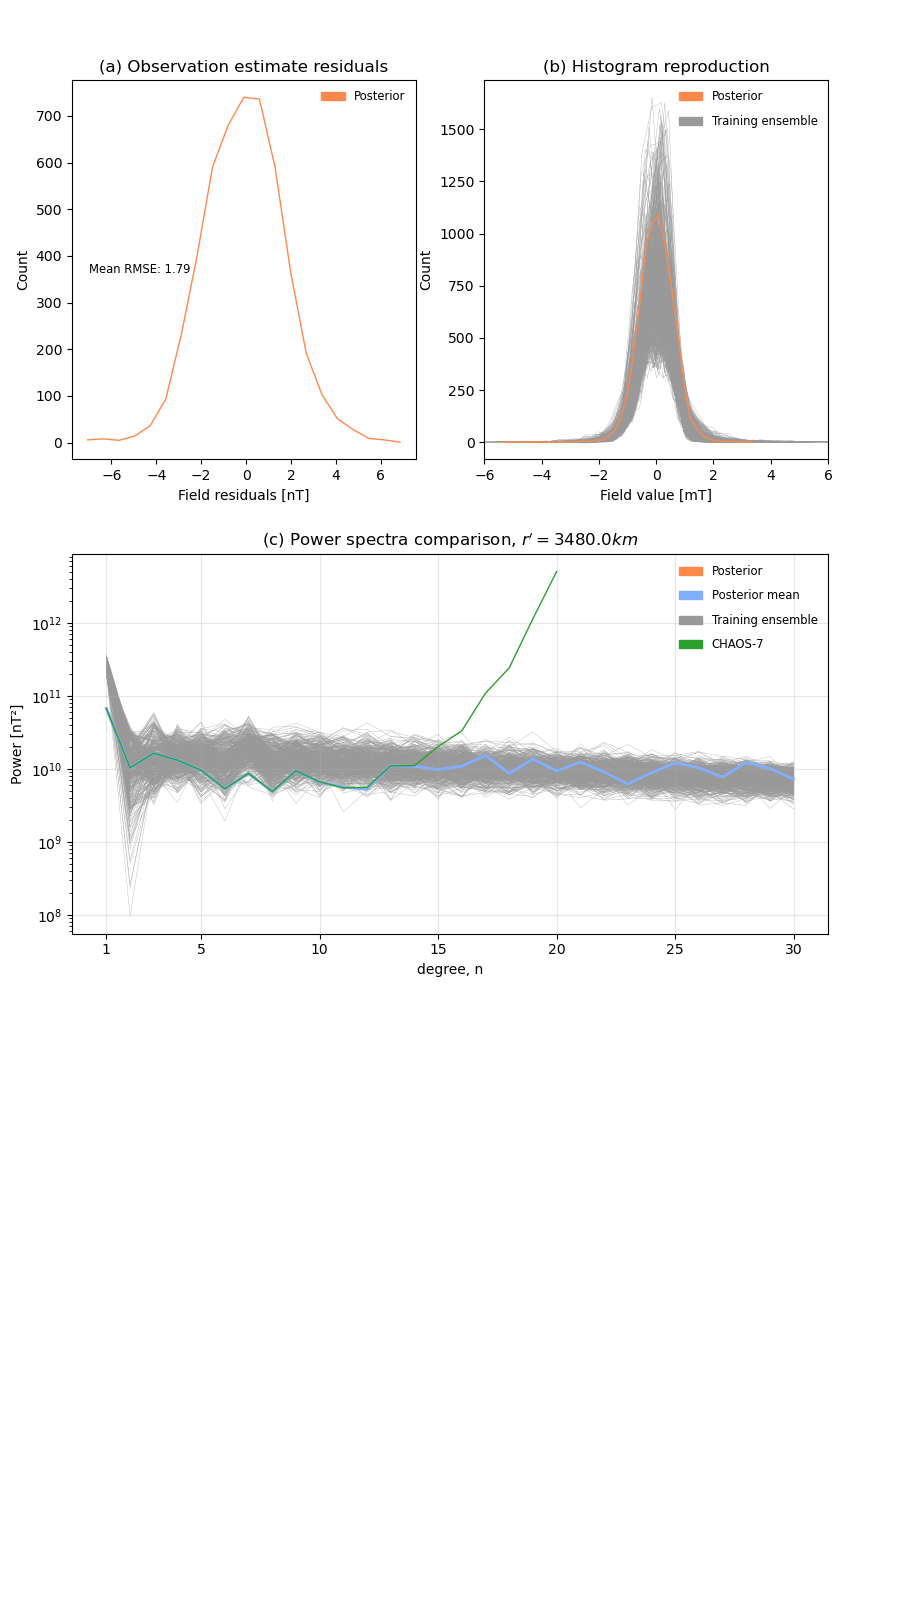

In [174]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
mt_util.plot_sdssim_reproduce(core, core.m_DSS_res, m_equiv_lsq = None, truth_obj = None,
                              lags_use = 1000, spec_r_at = core.r_cmb, spec_show_differences = False,
                              spec_ti_ens = True, lwidth = 1.0, label_fontsize = "small", ens_prior = True,
                              model_dict = {"CHAOS-7"}, spec_chaos_time = date_start,
                              res_use = True, sv_use = False, unit_field = "[mT]",
                              unit_transform_n_to_m = True, patch_legend = True, hist_ti_ens_limit = [-6,6],
                              figsize=(9,16), hist_ti_ens = "all", hist_density = False,
                              hist_bins = 41, res_bins = 21, hist_pos_mean = False,
                              left=0.08, bottom=0.12, right=0.92, top=0.95, wspace = 0.2, hspace=0.25,
                              savefig = False, save_string = "case_core_vires_swarm_obs", save_dpi = 100)

<IPython.core.display.Javascript object>


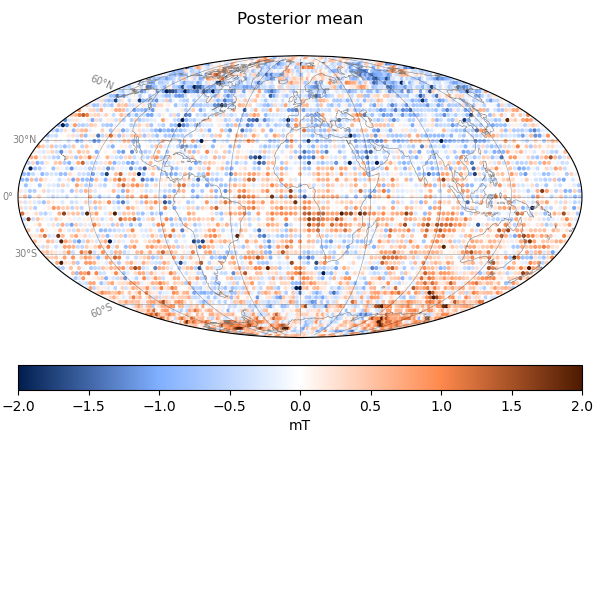

<IPython.core.display.Javascript object>


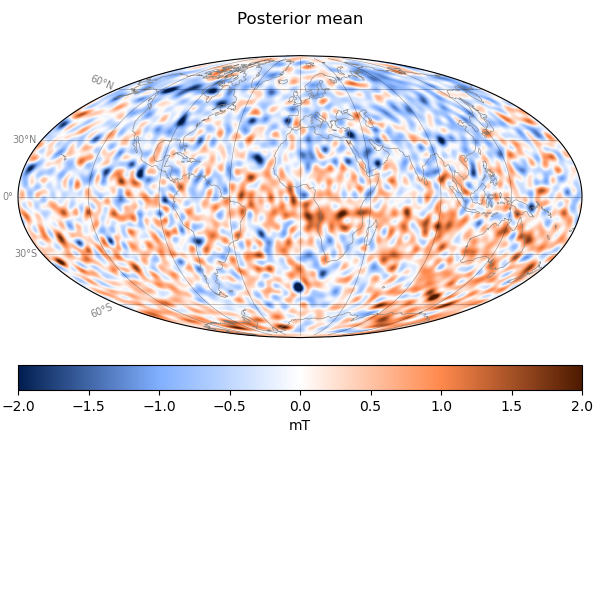

In [169]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

core.grid_glq(nmax = 60, r_at = core.r_cmb)

limit_data = [-2,2]
core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=core.m_DSS, limits_data = limit_data,
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Posterior mean', point_size=4,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

core.grid_glq(nmax = 400, r_at = core.r_cmb)

set_nmax = shc_grid

core.ensemble_B(core.g_spec, nmax = 60, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0].copy()

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=zs_eqa, limits_data = limit_data,
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Posterior mean', point_size=0.1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

core.ensemble_B(core.g_spec, nmax = 30, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0].copy()

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=zs_eqa, limits_data = limit_data,
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Posterior mean', point_size=0.1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

# n = 42

<IPython.core.display.Javascript object>


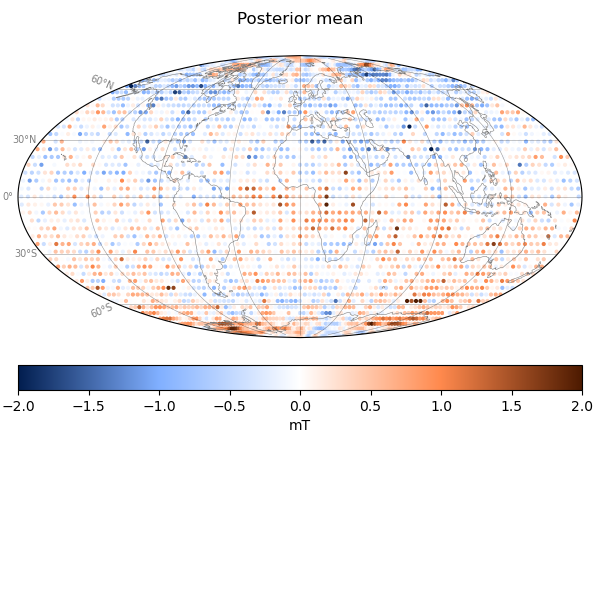

<IPython.core.display.Javascript object>


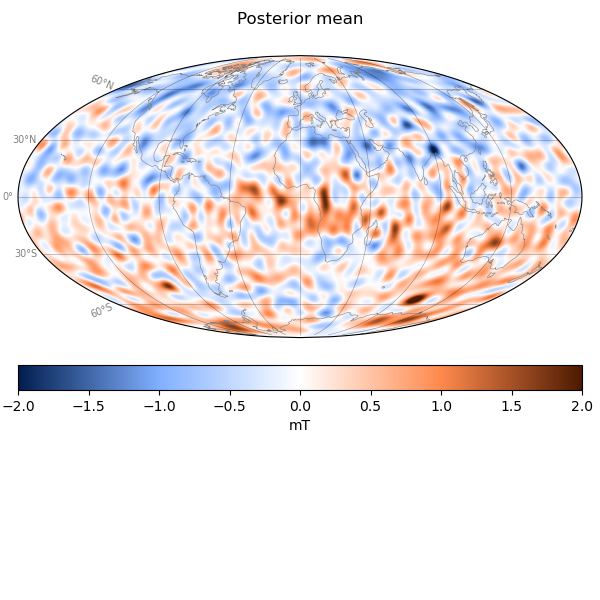

In [156]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

limit_data = [-2,2]
core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=core.m_DSS, limits_data = limit_data,
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Posterior mean', point_size=4,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

core.grid_glq(nmax = 400, r_at = core.r_cmb)

set_nmax = shc_grid

core.ensemble_B(core.g_spec, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0].copy()

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=zs_eqa, limits_data = limit_data,
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Posterior mean', point_size=0.1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

<IPython.core.display.Javascript object>


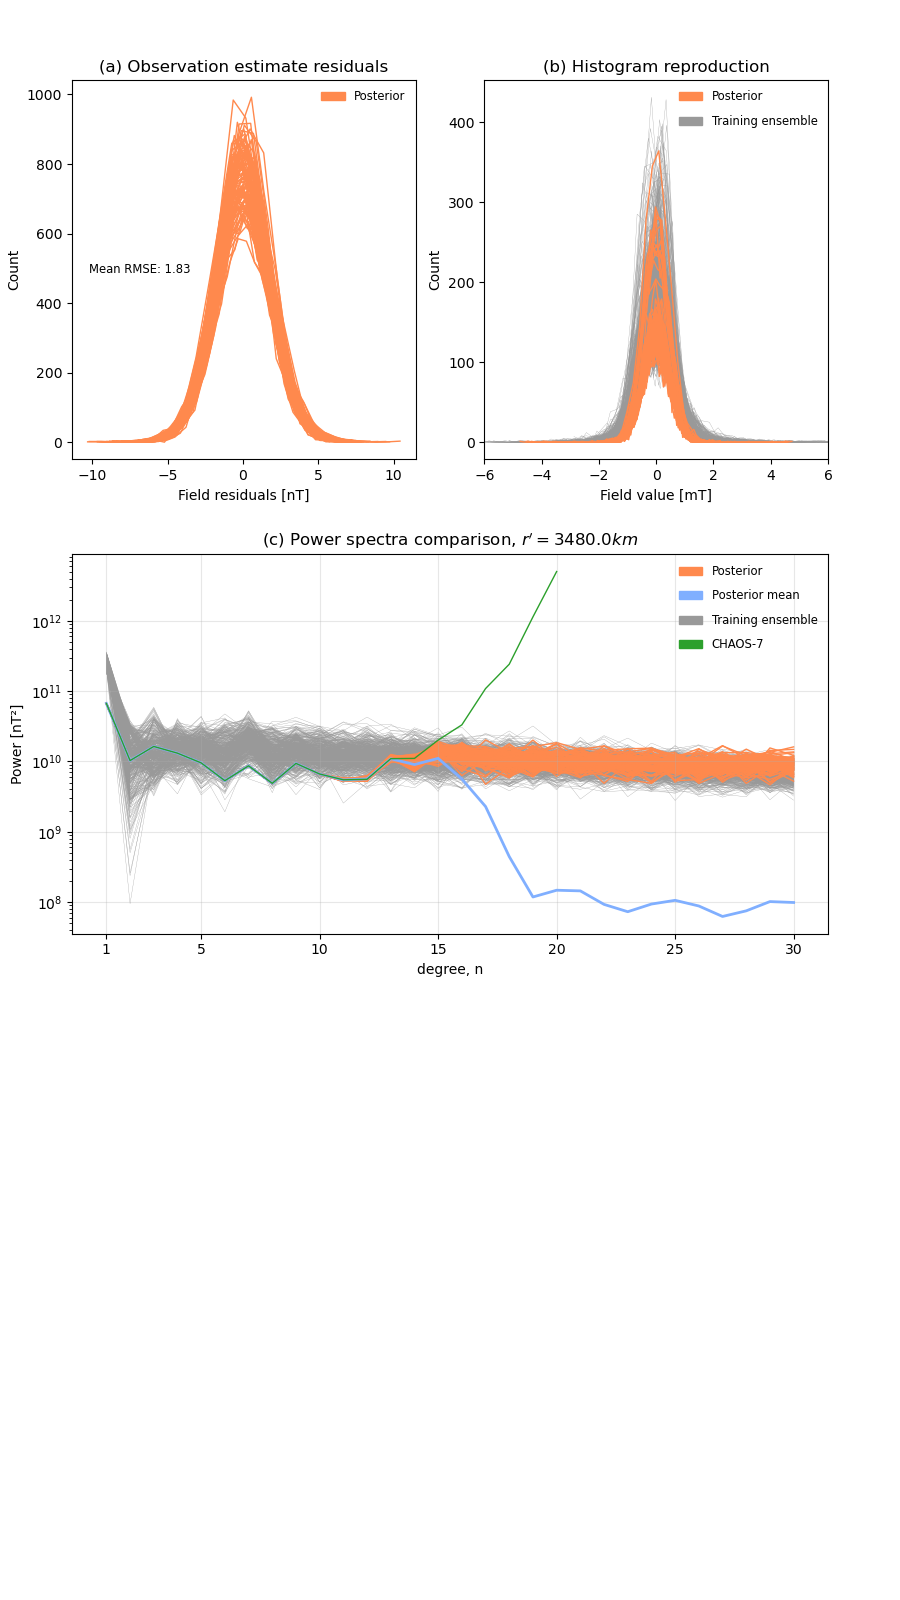

In [29]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
mt_util.plot_sdssim_reproduce(core, core.m_DSS_res, m_equiv_lsq = None, truth_obj = None,
                              lags_use = 1000, spec_r_at = core.r_cmb, spec_show_differences = False,
                              spec_ti_ens = True, lwidth = 1.0, label_fontsize = "small", ens_prior = True,
                              model_dict = {"CHAOS-7"}, spec_chaos_time = date_start,
                              res_use = True, sv_use = False, unit_field = "[mT]",
                              unit_transform_n_to_m = True, patch_legend = True, hist_ti_ens_limit = [-6,6],
                              figsize=(9,16), hist_ti_ens = "all", hist_density = False,
                              hist_bins = 41, res_bins = 21, hist_pos_mean = False,
                              left=0.08, bottom=0.12, right=0.92, top=0.95, wspace = 0.2, hspace=0.25,
                              savefig = False, save_string = "case_core_vires_swarm_obs", save_dpi = 300)

In [30]:
date_start_str = "Sy" + str(date_start).replace("[","").replace("]","").replace(" ", "m").replace(",","")
date_start_str = "d".join(date_start_str.rsplit("m", 1))
date_end_str = "Ey" + str(date_end).replace("[","").replace("]","").replace(" ", "m").replace(",","")
date_end_str = "d".join(date_end_str.rsplit("m", 1))

str_append = "_Ce{}_{}_{}_{}_Np{}".format(C_e_const,samp_step, date_start_str, date_end_str, N_sim)

core.pickle_save_self(nb_name, name_append = str_append)


Saving job

Job saved and finished


In [24]:
#core.grid_glq(nmax = 256, r_at = core.r_cmb)
#core.grid_glq(nmax = 120, r_at = core.r_cmb)
core.grid_glq(nmax = 400, r_at = core.r_cmb)

set_nmax = shc_grid

core.ensemble_B(core.g_spec, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0,:].copy()

#core.g_spec_mean = np.mean(core.g_spec,axis=1)
core.ensemble_B(core.g_spec_mean, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_mean_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#core.ensemble_B(s_sat.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#prior_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_lsq_equiv, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#lsq_eqa = core.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


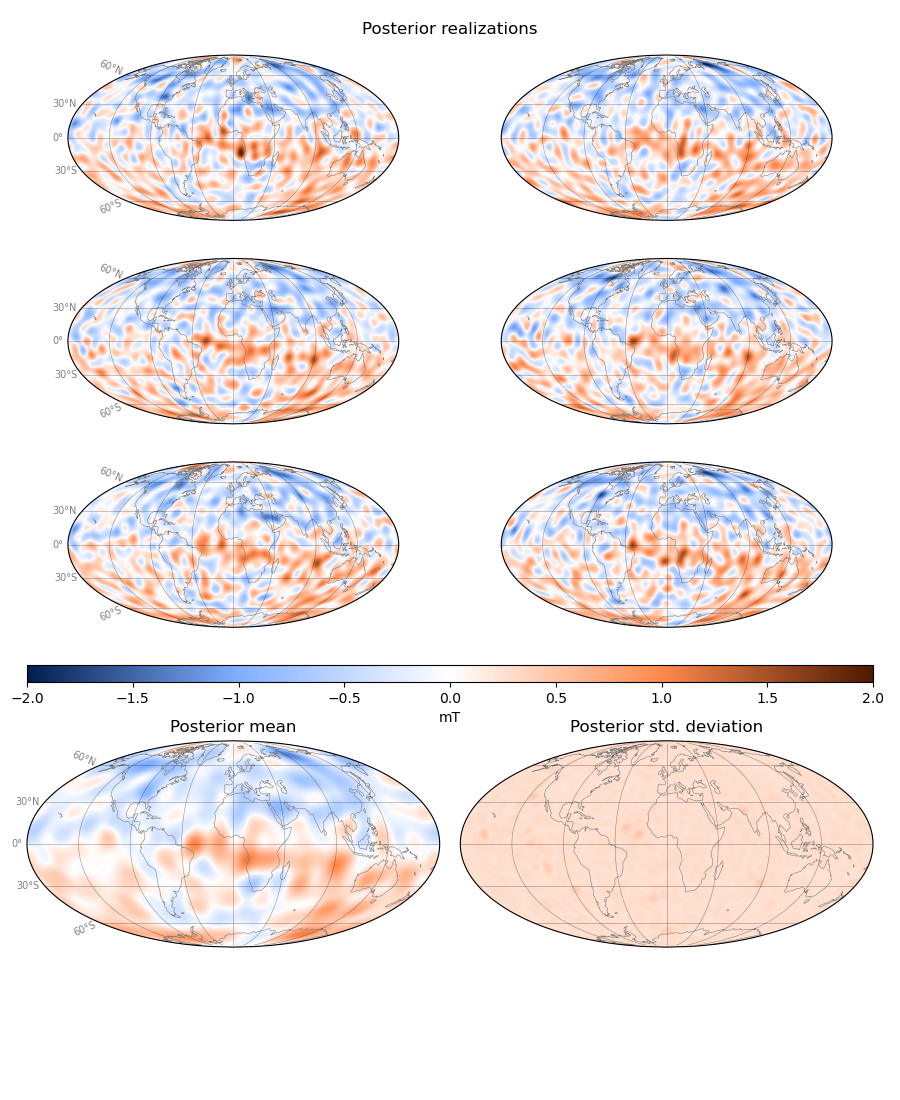

In [28]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.grid_phi, 90-core.grid_theta, zs_eqa, 
                        field_compare = None, field_lsq = None, field_mean = zs_mean_eqa,
                        tile_size_row = 4, tile_size_column = 2, 
                        figsize=(9,11), limit_for_SF = 10**6, point_size = 0.1, cbar_mm_factor = 1, cbar_limit = [-2,2],
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = True,
                        cbar_h = 0.1, cbar_text = "mT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.25, 
                        savefig = False, save_string = "case_core_vires_swarm_obs", save_path = "images/",
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)
